This tutorial is intended for experimentalists who have a dataset of electrophysiological recordings (e.g., EEG) and want to use `ncpi` to estimate plausible circuit parameters underlying their data. We will use the same pipeline configuration presented in the reference paper for the `ncpi` library. This configuration has been shown to perform reliably with both LFP and EEG datasets included in our study.

**To apply this pipeline to your own data, simply modify the dataframe creation step at the beginning of the notebook to load your dataset—no other changes are needed!**

We will first create a synthetic EEG dataset. This dataset simulates electrophysiological recordings (EEG) with the following structure:

- **Columns**:
  - `ID`: Unique identifier for each subject (10 IDs in total).
  - `Group`: Indicates the group of the subject (`Control` or `Test`).
  - `Epoch`: The epoch number (100 epochs per subject).
  - `Sensor`: The EEG sensor label (19 sensors per epoch).
  - `Data`: The EEG signal, represented as a 1D array of 2000 time points.
  - `Recording`: The type of recording (`EEG`).
  - `fs`: Sampling frequency (100 Hz).

- **Groups**:
  - `Control`: Subjects in the control group have signals low-pass filtered with a cutoff frequency of 10 Hz.
  - `Test`: Subjects in the test group have signals low-pass filtered with a cutoff frequency of 20 Hz.

- **Signal Properties**:
  - Each signal is a random noise sequence filtered with a low-pass Butterworth filter to mimic electrophysiological dynamics.
  - The difference in cutoff frequencies introduces distinct temporal properties between the control and test groups.

- **Dataset Size**:
  - Total rows: \(10 \times 100 \times 19 = 19,000\) rows.
  - Each row corresponds to a specific combination of subject, epoch, and sensor.

To use your dataset, you'll need to fill in the columns of the pandas DataFrame with your own data.

DataFrame shape: (19000, 7)


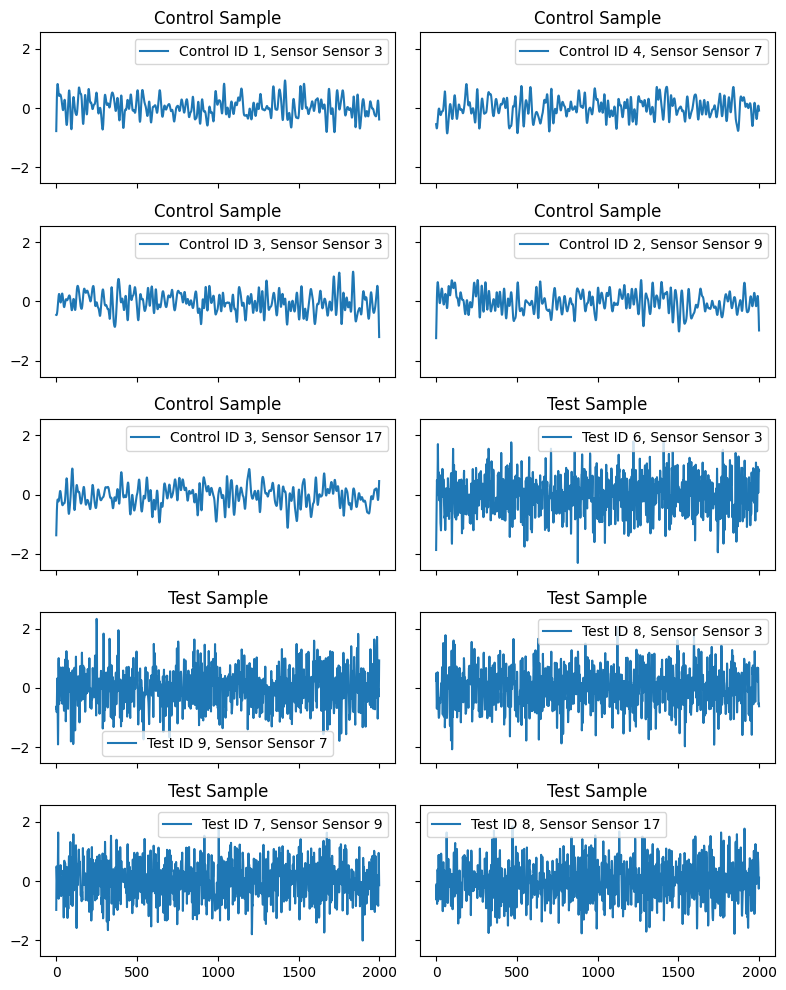

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Parameters
n_ids = 10
n_epochs = 100
n_sensors = 19
fs = 100  # Sampling frequency
signal_length = 2000  # Number of time points
control_cutoff = 5  # Low-pass filter cutoff for control group
test_cutoff = 20  # Low-pass filter cutoff for test group

# Generate low-pass filter
def low_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Generate synthetic data
data = []
for id_num in range(1, n_ids + 1):
    group = 'Control' if id_num <= n_ids // 2 else 'Test'
    cutoff = control_cutoff if group == 'Control' else test_cutoff
    for epoch in range(n_epochs):
        for sensor in range(n_sensors):
            # Generate random signal and apply low-pass filter
            raw_signal = np.random.randn(signal_length)
            filtered_signal = low_pass_filter(raw_signal, cutoff, fs)
            data.append({
                'ID': id_num,
                'Group': group,
                'Epoch': epoch,
                'Sensor': f'Sensor {sensor + 1}',
                'Data': filtered_signal,
                'Recording': 'EEG',
                'fs': fs
            })

# Create DataFrame
df = pd.DataFrame(data)
print(f"DataFrame shape: {df.shape}")

# Separate control and test groups
control_data = df[df['Group'] == 'Control']
test_data = df[df['Group'] == 'Test']

# Randomly select 5 samples from each group
control_samples = control_data.sample(5, random_state=42)
test_samples = test_data.sample(5, random_state=42)

# Plot the samples
fig, axes = plt.subplots(5, 2, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, (idx, row) in enumerate(control_samples.iterrows()):
    axes[i].plot(row['Data'], label=f"Control ID {row['ID']}, Sensor {row['Sensor']}")
    axes[i].legend()
    axes[i].set_title("Control Sample")

for i, (idx, row) in enumerate(test_samples.iterrows(), start=5):
    axes[i].plot(row['Data'], label=f"Test ID {row['ID']}, Sensor {row['Sensor']}")
    axes[i].legend()
    axes[i].set_title("Test Sample")

plt.tight_layout()
plt.show()

In this section, you can choose whether to download simulation data and machine learning models from Zenodo or load them from a local directory. If you already have the data locally, set `zenodo_dw_sim` to `False` and configure the `zenodo_dir_sim` variable to point to the correct path.

In [2]:
# Choose to either download data from Zenodo (True) or load it from a local path (False).
# Important: the zenodo downloads will take a while, so if you have already downloaded the data, set this to False and
# configure the zenodo_dir variables to point to the local paths where the data is stored.
zenodo_dw_sim = False # simulation data

# Zenodo URL that contains the simulation data and ML models (used if zenodo_dw_sim is True)
zenodo_URL_sim = "https://zenodo.org/api/records/15351118"

# Paths to zenodo files
zenodo_dir_sim = "/DATA/zenodo_sim_files"

# Method used to compute the features
method = 'catch22'

# ML model used to compute the predictions (MLPRegressor, Ridge or SBI-based models)
ML_model = 'MLPRegressor'

This section loads the simulation data, including model parameters (`theta`) and features (`X`). It also loads the inverse model (e.g., `MLPRegressor`, `Ridge`, or `SBI` models) and prepare it for inference. The model and its associated scaler are copied to the local `data` directory for use in subsequent steps.

In [3]:
import os
import time
import pickle
import shutil
import ncpi
from ncpi import tools

# Download simulation data and ML models
if zenodo_dw_sim:
    print('\n--- Downloading simulation data and ML models from Zenodo.')
    start_time = time.time()
    tools.download_zenodo_record(zenodo_URL_sim, download_dir=zenodo_dir_sim)
    end_time = time.time()
    print(f"All files downloaded in {(end_time - start_time) / 60:.2f} minutes.")

# Load parameters of the model (theta) and features (X) from simulation data
print('\n--- Loading simulation data.')
start_time = time.time()

try:
    with open(os.path.join(zenodo_dir_sim, 'data', method, 'sim_theta'), 'rb') as file:
        theta = pickle.load(file)
    with open(os.path.join(zenodo_dir_sim, 'data', method, 'sim_X'), 'rb') as file:
        X = pickle.load(file)
except Exception as e:
    print(f"Error loading simulation data: {e}")

# Print info
print('theta:')
for key, value in theta.items():
    if isinstance(value, np.ndarray):
        print(f'--Shape of {key}: {value.shape}')
    else:
        print(f'--{key}: {value}')
print(f'Shape of X: {X.shape}')

end_time = time.time()
print(f"Done in {(end_time - start_time):.2f} sec.")

# Load the Inference objects and add the simulation data
print('\n--- Loading the inverse model.')
start_time = time.time()

# Create inference object
inference = ncpi.Inference(model=ML_model)
inference.add_simulation_data(X, theta['data'])

# Create folder to save results
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists(os.path.join('data', method)):
    os.makedirs(os.path.join('data', method))

# Transfer model and scaler to the data folder
if ML_model == 'MLPRegressor':
    folder = 'MLP'
elif ML_model == 'Ridge':
    folder = 'Ridge'
elif ML_model == 'NPE':
    folder = 'SBI'

shutil.copy(
    os.path.join(zenodo_dir_sim, 'ML_models/4_param', folder, method, 'scaler'),
    os.path.join('data', 'scaler.pkl')
)

shutil.copy(
    os.path.join(zenodo_dir_sim, 'ML_models/4_param', folder, method, 'model'),
    os.path.join('data', 'model.pkl')
)

if ML_model == 'NPE':
    shutil.copy(
        os.path.join(zenodo_dir_sim, 'ML_models/4_param', folder, method,
                     'density_estimator'),
        os.path.join('data', 'density_estimator.pkl')
    )

end_time = time.time()
print(f'Done in {(end_time - start_time):.2f} sec')


--- Loading simulation data.
theta:
--Shape of data: (1977238, 7)
--parameters: ['J_EE', 'J_IE', 'J_EI', 'J_II', 'tau_syn_E', 'tau_syn_I', 'J_ext']
Shape of X: (1977238, 22)
Done in 0.40 sec.

--- Loading the inverse model.
Done in 3.72 sec


We next configur the feature extraction method. Depending on the chosen method (`catch22` or `power_spectrum_parameterization_1`), the appropriate parameters are set. The features are then computed from the synthetic EEG dataset and stored in the `emp_data` DataFrame.

In [4]:
# Parameters of the feature extraction method
if method == 'catch22':
    params = None
elif method == 'power_spectrum_parameterization_1':
    fooof_setup_emp = {'peak_threshold': 1.,
                       'min_peak_height': 0.,
                       'max_n_peaks': 5,
                       'peak_width_limits': (10., 50.)}
    params={'fs': pd['fs'][0],
           'fmin': 5.,
           'fmax': 45.,
           'fooof_setup': fooof_setup_emp,
           'r_squared_th':0.9}

# Compute features
if method == 'catch22':
    feat_mt = 'catch22'
elif method == 'power_spectrum_parameterization_1':
    feat_mt = 'power_spectrum_parameterization'

features = ncpi.Features(method=feat_mt, params=params)
emp_data = features.compute_features(df)

# Keep only the aperiodic exponent (1/f slope)
if method == 'power_spectrum_parameterization_1':
    emp_data['Features'] = emp_data['Features'].apply(lambda x: x[1])

end_time = time.time()
print(f'Done in {(end_time - start_time):.2f} sec')

Computing features: 100%|██████████| 323/323 [00:20<00:00, 15.48it/s]

Done in 25.20 sec


In this step, we compute predictions for the circuit parameters based on the extracted features. The predictions are appended to the `emp_data` DataFrame, and the recurrent synaptic conductances are replaced with the E/I ratio for further analysis.

In [6]:
# Create a scaler for the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Compute predictions from the empirical data
print('\n--- Computing predictions from empirical data.')
start_time = time.time()
# Predict the parameters from the features of the empirical data
predictions = inference.predict(np.array(emp_data['Features'].tolist()), scaler=scaler)

# Append the predictions to the DataFrame
pd_preds = pd.DataFrame({'Predictions': predictions})
emp_data = pd.concat([emp_data, pd_preds], axis=1)
end_time = time.time()
print(f'Done in {(end_time - start_time)/60.} min')

# Replace parameters of recurrent synaptic conductances with the ratio (E/I)_net
E_I_net = emp_data['Predictions'].apply(lambda x: (x[0]/x[2]) / (x[1]/x[3]))
others = emp_data['Predictions'].apply(lambda x: x[4:])
emp_data['Predictions'] = (np.concatenate((E_I_net.values.reshape(-1,1),
                                           np.array(others.tolist())), axis=1)).tolist()


--- Computing predictions from empirical data.


Computing predictions: 100%|██████████| 33/33 [00:51<00:00,  1.55s/it]

Done in 0.8533495783805847 min


We now visualize the distribution of the predicted parameters for each group using histograms. Each subplot corresponds to a specific parameter, and the data is grouped by the experimental groups (e.g., control and test).

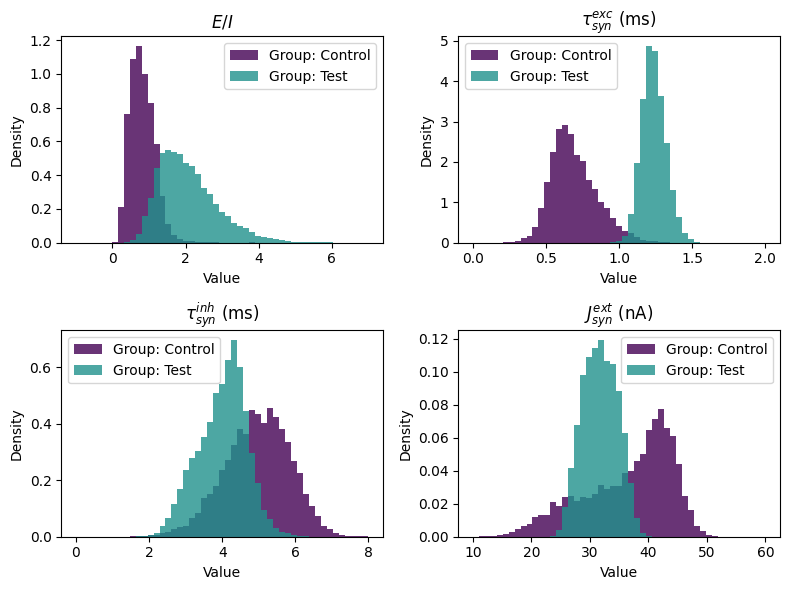

In [7]:
# Convert 'Predictions' column to a NumPy array for easier manipulation
predictions_array = np.array(emp_data['Predictions'].tolist())

# Extract unique groups
groups = emp_data['Group'].unique()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

# Titles for the subplots
titles = [r'$E/I$', r'$\tau_{syn}^{exc}$ (ms)', r'$\tau_{syn}^{inh}$ (ms)', r'$J_{syn}^{ext}$ (nA)']

# Define a colormap
cmap = plt.colormaps['viridis']

# bins for histograms
bins = [np.linspace(-1, 7, 50),
        np.linspace(0, 2, 50),
        np.linspace(0, 8, 50),
        np.linspace(10, 60, 50)]

# Plot each parameter
for i in range(4):
    for j, group in enumerate(groups):
        group_data = predictions_array[emp_data['Group'] == group, i]
        axes[i].hist(group_data, bins=bins[i], alpha=0.8, label=f'Group: {group}', density=True, color = cmap(j / len(groups)))
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()

Finally, we generate boxplots for each predicted parameter, grouped by experimental condition. To assess group differences, we compute effect sizes (Cohen's d) comparing the control group to each experimental group, with annotations added directly to the plots. Optionally, a linear mixed-effects (lmer) analysis can also be performed using the corresponding method from the Analysis class.



--- Group: Test


--- Group: Test


--- Group: Test


--- Group: Test


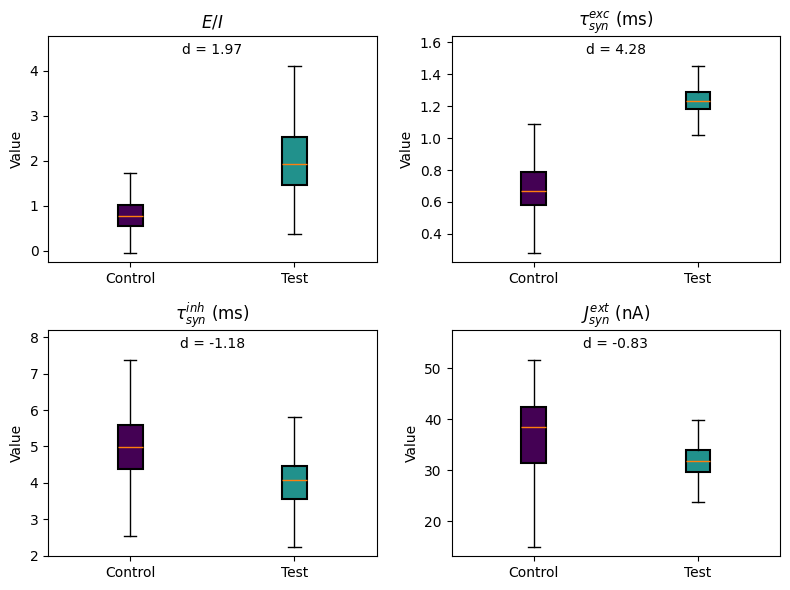

In [8]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

# Define the control group name
ctrl_group = 'Control'

# Remove control group from the list of groups
new_groups = [group for group in groups if group != ctrl_group]

# Loop through each parameter
for param_idx, param_name in enumerate(titles):
    # Create a new DataFrame for the parameter
    data_param = emp_data.copy()

    # Replace the 'Predictions' column with the parameter of interest
    data_param['Y'] = predictions_array[:, param_idx]  # Extract the parameter of interest

    # Drop the original 'Predictions' column
    data_param = data_param.drop(columns=['Predictions'])

    # Initialize the Analysis object
    Analysis = ncpi.Analysis(data_param)

    # Perform a Cohen's d test
    stat_result = Analysis.cohend(control_group=ctrl_group, data_col='Y',data_index=-1)

    # Create a boxplot
    data = [predictions_array[emp_data['Group'] == group, param_idx] for group in groups]
    boxplots = axes[param_idx].boxplot(data, patch_artist=True, showfliers=False, tick_labels=groups)
    for i, box in enumerate(boxplots['boxes']):
        # Set the color of the box
        box.set_facecolor(cmap(i / len(groups)))
        box.set_edgecolor('black')
        box.set_linewidth(1.5)
    axes[param_idx].set_title(param_name)
    axes[param_idx].set_ylabel('Value')

    # y-axis max and min
    y_max = axes[param_idx].get_ylim()[1]
    y_min = axes[param_idx].get_ylim()[0]
    delta = (y_max - y_min) * 0.1

    for i, group in enumerate(new_groups):
        d_value = stat_result[f'{group}vs{ctrl_group}']['d']
        if d_value.empty:
            continue

        pp = f'd = {d_value[0]:.2f}'
        offset = delta * i

        axes[param_idx].text(
            i + 1.5,
            y_max + offset,
            pp,
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

    # Change y-lim
    axes[param_idx].set_ylim([y_min, y_max + delta*(len(new_groups))])

plt.tight_layout()
plt.show()